In [1]:
import pandas as pd

In [2]:
pd.set_option('display.max_columns', None)

# COVID-19

In [3]:
data = pd.read_csv('latest_raw.csv', error_bad_lines=False)

In [4]:
data.ENTIDAD.unique()

array(['Sinaloa', 'Jalisco', 'Chihuahua', 'Ciudad de Mexico',
       'Nuevo Leon', 'Morelos', 'Tabasco', 'Mexico', 'Coahuila',
       'Tamaulipas', 'Guanajuato', 'San Luis Potosi', 'Yucatan',
       'Baja California', 'Puebla', 'Zacatecas', 'Hidalgo',
       'Baja California Sur', 'Sonora', 'Michoacan', 'Veracruz',
       'Aguascalientes', 'Durango', 'Guerrero', 'Oaxaca', 'Tlaxcala',
       'Nayarit', 'Chiapas', 'Queretaro', 'Quintana Roo', 'Colima',
       'Campeche'], dtype=object)

In [5]:
#data.isnull().head(), data.isnull().tail()

In [6]:
data.isnull().values.any()

True

In [7]:
data.isnull().values.sum()

6

In [8]:
# null_data = data[data.isnull().any(axis=1)] # missing city of residente

In [9]:
# Totals and delta

In [10]:
df = data[~data.isnull().any(axis=1)]

In [11]:
df = df[df['RESULTADO']==1]

In [12]:
df = df[~df.FECHA_DEF.str.startswith(('9999'))]

In [13]:
df = data[['FECHA_ARCHIVO', 'FECHA_SINTOMAS', 'DELAY', 'ENTIDAD']]

In [14]:
df = df.rename(
    columns = {
        'FECHA_ARCHIVO':'Date_Confirmed',
        'FECHA_SINTOMAS':'Date_Symptoms',
        'FECHA_DEF':'Date_Death',
        'RESULTADO':'Status',
        'ENTIDAD':'Region',
        'DELAY':'Delay'
    })

In [15]:
df['Date_Confirmed'] = pd.to_datetime(df.Date_Confirmed, format='%Y-%m-%d', errors='coerce')
df['Date_Confirmed'] = df['Date_Confirmed'].dt.strftime('%Y-%m-%d')

In [16]:
    # Region delta (ie, new cases)
cum_df = (df.groupby(['Region','Date_Confirmed'])['Date_Confirmed'].count()).to_frame()

In [17]:
    # Rename because duplicate index
cum_df['Region_Delta'] = cum_df['Date_Confirmed']

In [18]:
    # Region cumulative by date
cum_df['Region_Cumulative'] = cum_df.groupby(['Region'])['Region_Delta'].cumsum()

In [19]:
    # Clean up
cum_df = cum_df.drop(['Date_Confirmed'], axis=1)

In [20]:
# To view full table:
# from IPython.core.display import HTML
# display(HTML(cum_df.to_html()))

In [21]:
cum_df

Region_Delta  Region_Cumulative
Region         Date_Confirmed                                 
Aguascalientes 2020-04-12               699                699
               2020-04-13                 8                707
               2020-04-14                95                802
               2020-04-15                33                835
               2020-04-16                43                878
...                                     ...                ...
Zacatecas      2020-05-19                11               1209
               2020-05-20                51               1260
               2020-05-21                34               1294
               2020-05-22                35               1329
               2020-05-23                26               1355

[1339 rows x 2 columns]

# Tables

In [22]:
# Read

In [23]:
pivot_tbl_cum = cum_df.reset_index().pivot('Region','Date_Confirmed','Region_Cumulative').T.reset_index()
pivot_tbl_daily = cum_df.reset_index().pivot('Region','Date_Confirmed','Region_Delta').T.reset_index()

In [24]:
# Save

In [25]:
pivot_tbl_cum.to_csv('output_data/total-mexico-covid19.csv', index=False)
pivot_tbl_daily.fillna(0).to_csv('output_data/daily-mexico-covid19.csv', index=False)

In [26]:
# Set datetime

In [27]:
pivot_tbl_cum['Date_Confirmed'] = pd.to_datetime(pivot_tbl_cum.Date_Confirmed, format='%Y-%m-%d')
pivot_tbl_cum['Date_Confirmed'] = pivot_tbl_cum['Date_Confirmed'].dt.strftime('%Y-%m-%d')

In [28]:
# Set datetime

In [29]:
pivot_tbl_daily['Date_Confirmed'] = pd.to_datetime(pivot_tbl_daily.Date_Confirmed, format='%Y-%m-%d')
pivot_tbl_daily['Date_Confirmed'] = pivot_tbl_daily['Date_Confirmed'].dt.strftime('%Y-%m-%d')

In [30]:
# Set index

In [31]:
pivot_tbl_cum = pivot_tbl_cum.set_index(pd.DatetimeIndex(pivot_tbl_cum['Date_Confirmed']))
pivot_tbl_daily = pivot_tbl_daily.set_index(pd.DatetimeIndex(pivot_tbl_daily['Date_Confirmed']))

# Plots

In [32]:
import janitor

In [33]:
pivot_tbl_cum = pivot_tbl_cum.filter_date('Date_Confirmed','2020-04-13','2022-12-31')
pivot_tbl_daily = pivot_tbl_daily.filter_date('Date_Confirmed','2020-04-13','2022-12-31')

In [34]:
from numpy import *
import math
import matplotlib.pyplot as plt

### Confirmed cases

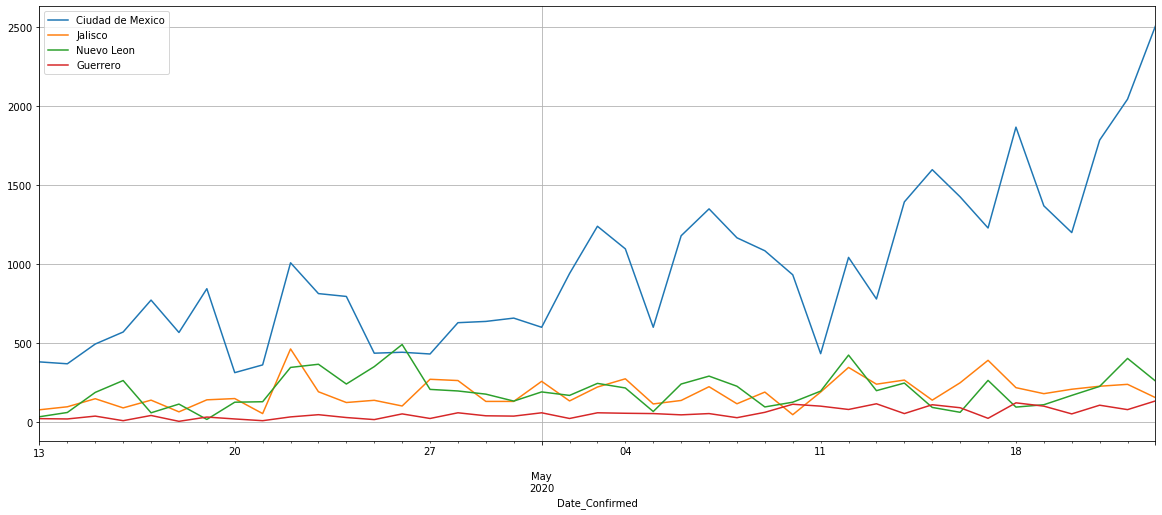

In [35]:
plt.figure(figsize=(20,8))

for state in ['Ciudad de Mexico', 'Jalisco', 'Nuevo Leon', 'Guerrero']:
    pivot_tbl_daily[state].fillna(0).plot()

plt.legend()
plt.grid(True)
plt.show()

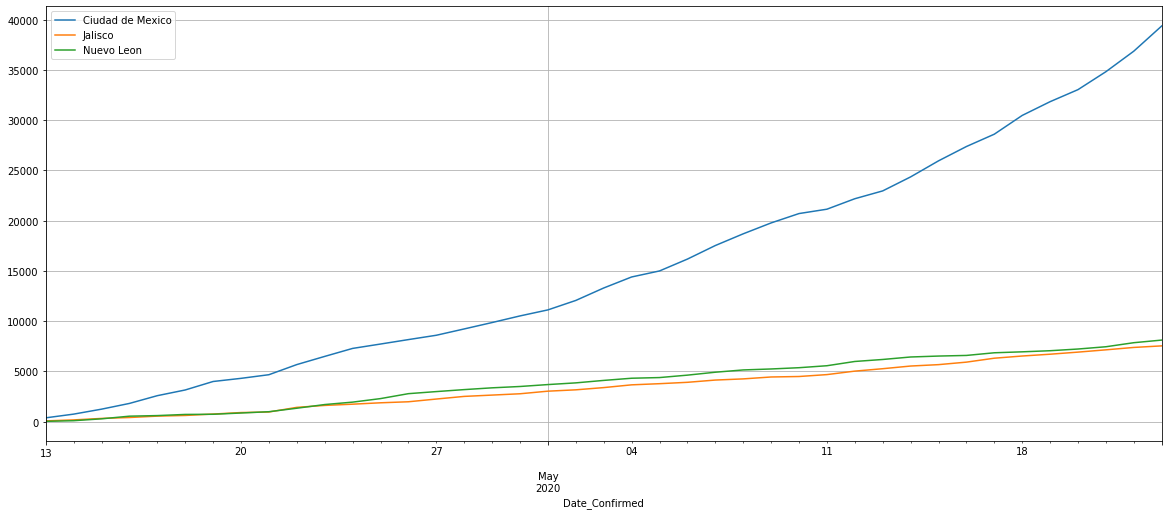

In [36]:
plt.figure(figsize=(20,8))

for state in ['Ciudad de Mexico', 'Jalisco', 'Nuevo Leon']:
    pivot_tbl_daily[state].fillna(0).cumsum().plot()

plt.legend()
plt.grid(True)
plt.show()

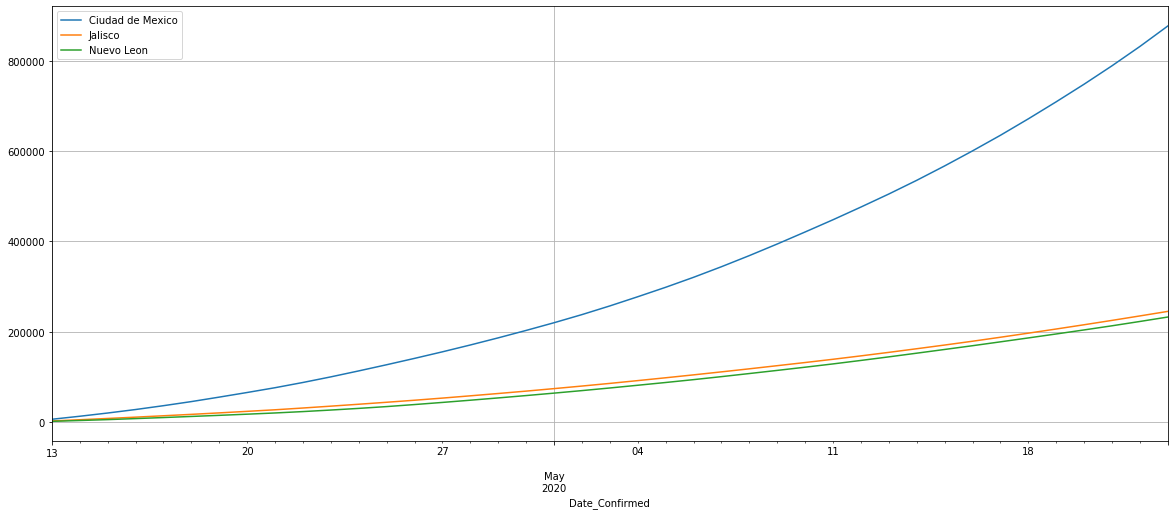

In [37]:
plt.figure(figsize=(20,8))

for state in ['Ciudad de Mexico', 'Jalisco', 'Nuevo Leon']:
    pivot_tbl_cum[state].fillna(0).cumsum().plot()

plt.legend()
plt.grid(True)
plt.show()

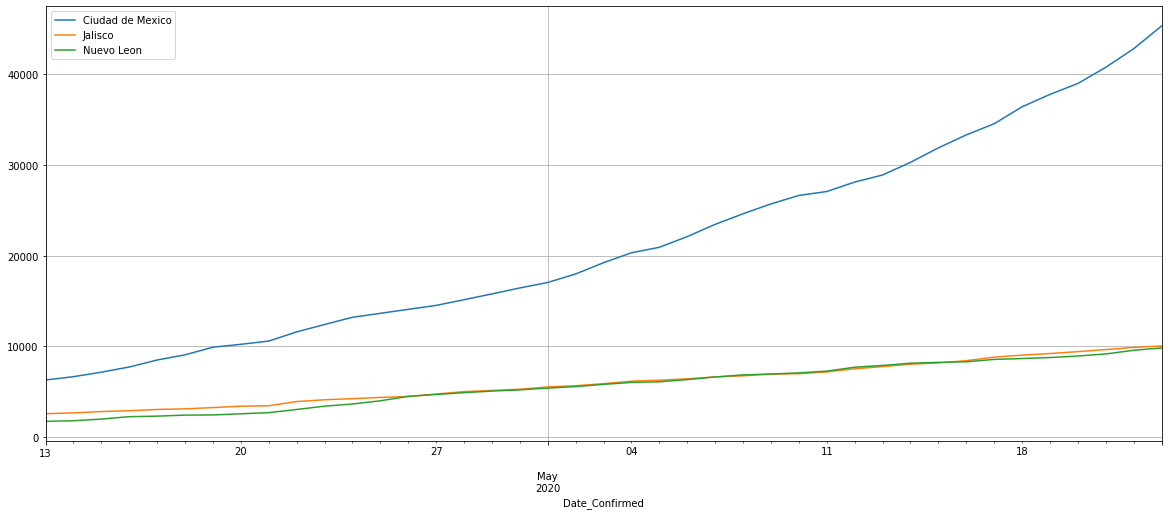

In [38]:
plt.figure(figsize=(20,8))

for state in ['Ciudad de Mexico', 'Jalisco', 'Nuevo Leon']:
    pivot_tbl_cum[state].fillna(0).plot()

plt.legend()
plt.grid(True)
plt.show()

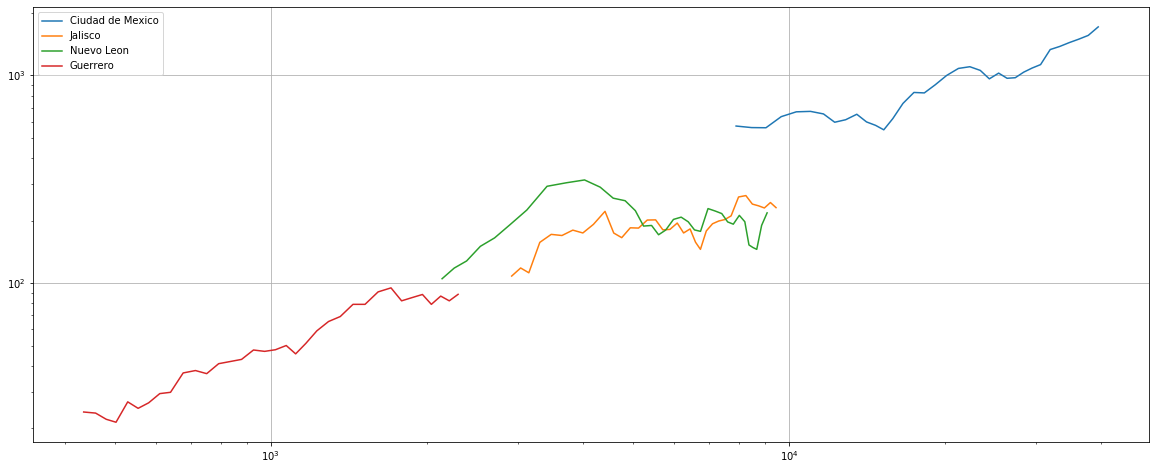

In [39]:
plt.figure(figsize=(20,8))

for state in ['Ciudad de Mexico', 'Jalisco', 'Nuevo Leon', 'Guerrero']:
    plt.plot(list(pivot_tbl_cum[state].dropna().rolling(window=7).mean()), list(pivot_tbl_daily[state].dropna().rolling(window=7).mean()), label=state)

plt.legend()
plt.grid(True)

plt.yscale('log')
plt.xscale('log')

plt.show()

In [40]:
cum_df

Region_Delta  Region_Cumulative
Region         Date_Confirmed                                 
Aguascalientes 2020-04-12               699                699
               2020-04-13                 8                707
               2020-04-14                95                802
               2020-04-15                33                835
               2020-04-16                43                878
...                                     ...                ...
Zacatecas      2020-05-19                11               1209
               2020-05-20                51               1260
               2020-05-21                34               1294
               2020-05-22                35               1329
               2020-05-23                26               1355

[1339 rows x 2 columns]

In [41]:
# Needs fix !!!

# Starting at date w/certain number of cases
def select_min_cases(df, min):
    df2_state = []
    df2_dates = []
    df2_cases = []
    for state in df.columns:
        #print(df.columns)
        for index in range(len(df[state])):
            if df[state][index] > min:
                #print(state)
                #print(df[state].index[index])
                #print((df[state][index]))
                df2_state.append(state)
                df2_dates.append(df[state].index[index])
                df2_cases.append(df[state][index])
            #if df[state][index] < num:
                #print(None)
    #my_df = pd.DataFrame({'Region': pd.Series(df2_state), 'Date_Confirmed': pd.Series(df2_dates), 'Region_Cumulative': pd.Series(df2_cases)})
    #my_df = my_df.set_index(['Region','Date_Confirmed'])
    return df2

min_cases = select_min_cases(cum_df, 15).reset_index()
#min_cases = min_cases.drop(['index'], axis=1).reset_index()
#min_cases = min_cases.reset_index().pivot('Region','Date_Confirmed','Region_Cumulative').T.sort_index()
#min_cases = min_cases.fillna(method='ffill')
#daily_min_cases = min_cases.diff()

#plt.figure(figsize=(20,8))

#for state in ['Jalisco', 'Nuevo Leon']:
#    daily_min_cases[state].fillna(0).rolling(window=7).mean().plot()

#plt.legend()
#plt.grid(True)
#plt.show()

NameError: name 'df2' is not defined

In [ ]:
min_cases

In [ ]:
min_cases = select_min_cases(cum_df, 15)

In [ ]:
plt.figure(figsize=(20,8))

for state in ['Ciudad de Mexico', 'Jalisco', 'Nuevo Leon']:
    plt.plot(list(pivot_tbl_cum[state].dropna().rolling(window=7).mean()), list(pivot_tbl_daily[state].dropna().rolling(window=7).mean()), label = state)

plt.legend()
plt.grid(True)

plt.yscale('log')
plt.xscale('log')

plt.show()

### Lag in cases reported

In [48]:
import janitor
test = pivot_tbl_daily
b = test.filter_date('Date_Confirmed','2020-01-01','2022-12-31')

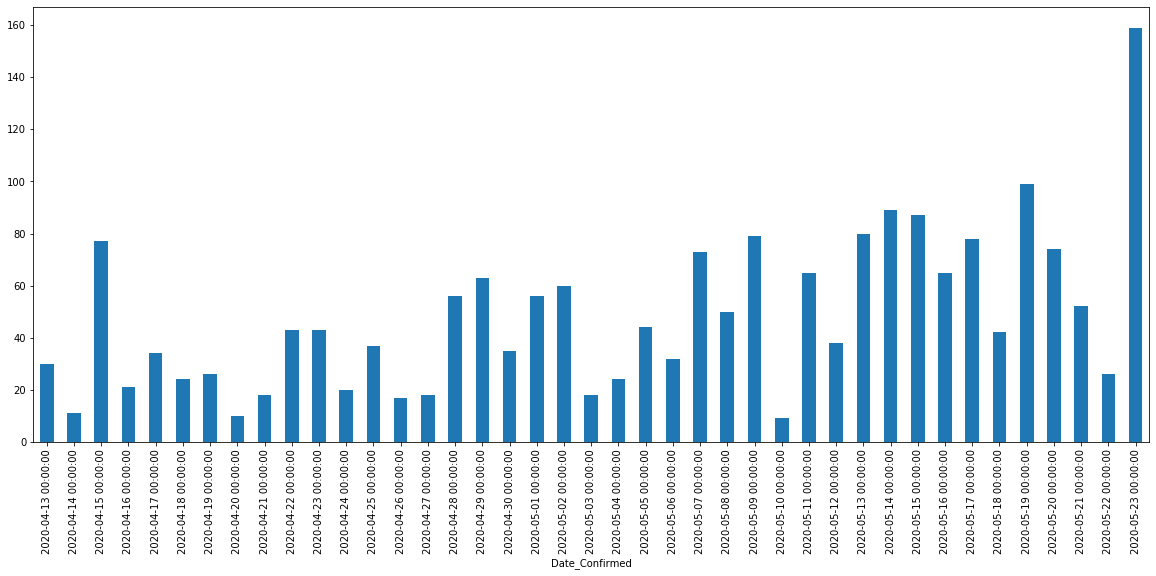

In [50]:
plt.figure(figsize=(20,8))
b['Tlaxcala'].plot(kind='bar', title='')